# Hubble Diagram Project

## Read Data

In [ ]:
import numpy as np
import astropy.table as ast

LOWZ_table = ast.Table.read("./data/DES-SN5YR_LOWZ_HEAD.FITS")
DES_table = ast.Table.read("./data/DES-SN5YR_DES_HEAD.FITS")
Foundation_table = ast.Table.read("./data/DES-SN5YR_Foundation_HEAD.FITS")
source_table = ast.Table.read(
    "./data/DES-Dovekie_HD.csv", format="csv", delimiter=" ", comment="#"
)
num_samples = len(source_table)

LOWZ_table["SNID_str"] = [cid.strip() for cid in LOWZ_table["SNID"].astype(str)]
DES_table["SNID_str"] = [cid.strip() for cid in DES_table["SNID"].astype(str)]
Foundation_table["SNID_str"] = [
    cid.strip() for cid in Foundation_table["SNID"].astype(str)
]
source_table["CID_str"] = [cid.strip() for cid in source_table["CID"]]
source_table['ID'] = range(num_samples) # 添加一个ID列以便后续排序

DES_sample = ast.join(
    source_table,
    DES_table,
    keys_left="CID_str",
    keys_right="SNID_str",
    join_type="inner",
)
LOWZ_sample = ast.vstack(
    [
        ast.join(
            source_table,
            LOWZ_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
        ast.join(
            source_table,
            Foundation_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
    ]
)
SN_sample = ast.vstack([DES_sample, LOWZ_sample], join_type="inner")
del SN_sample["SNID_str"], SN_sample["CID_str"]
SN_sample.sort('ID') # 按照ID排序以对应原始
SN_sample

VARNAMES:,CID,IDSURVEY,zHD,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,PROBIA_BEAMS,ID,SNID,IAUC,FAKE,MASK_FLUXCOR_SNANA,RA,DEC,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,REDSHIFT_HELIO,REDSHIFT_HELIO_ERR,REDSHIFT_FINAL,REDSHIFT_FINAL_ERR,REDSHIFT_QUALITYFLAG,MASK_REDSHIFT_SOURCE,VPEC,VPEC_ERR,HOSTGAL_NMATCH,HOSTGAL_NMATCH2,HOSTGAL_OBJID,HOSTGAL_FLAG,HOSTGAL_PHOTOZ,HOSTGAL_PHOTOZ_ERR,HOSTGAL_SPECZ,HOSTGAL_SPECZ_ERR,HOSTGAL_RA,HOSTGAL_DEC,HOSTGAL_SNSEP,HOSTGAL_DDLR,HOSTGAL_CONFUSION,HOSTGAL_LOGMASS,HOSTGAL_LOGMASS_ERR,HOSTGAL_LOGSFR,HOSTGAL_LOGSFR_ERR,HOSTGAL_LOGsSFR,HOSTGAL_LOGsSFR_ERR,HOSTGAL_COLOR,HOSTGAL_COLOR_ERR,HOSTGAL_ELLIPTICITY,HOSTGAL_OBJID2,HOSTGAL_SQRADIUS,HOSTGAL_OBJID_UNIQUE,HOSTGAL_MAG_g,HOSTGAL_MAG_r,HOSTGAL_MAG_i,HOSTGAL_MAG_z,HOSTGAL_MAGERR_g,HOSTGAL_MAGERR_r,HOSTGAL_MAGERR_i,HOSTGAL_MAGERR_z,HOSTGAL2_OBJID,HOSTGAL2_FLAG,HOSTGAL2_PHOTOZ,HOSTGAL2_PHOTOZ_ERR,HOSTGAL2_SPECZ,HOSTGAL2_SPECZ_ERR,HOSTGAL2_RA,HOSTGAL2_DEC,HOSTGAL2_SNSEP,HOSTGAL2_DDLR,HOSTGAL2_LOGMASS,HOSTGAL2_LOGMASS_ERR,HOSTGAL2_LOGSFR,HOSTGAL2_LOGSFR_ERR,HOSTGAL2_LOGsSFR,HOSTGAL2_LOGsSFR_ERR,HOSTGAL2_COLOR,HOSTGAL2_COLOR_ERR,HOSTGAL2_ELLIPTICITY,HOSTGAL2_OBJID2,HOSTGAL2_SQRADIUS,HOSTGAL2_OBJID_UNIQUE,HOSTGAL2_MAG_g,HOSTGAL2_MAG_r,HOSTGAL2_MAG_i,HOSTGAL2_MAG_z,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL_SB_FLUXCAL_g,HOSTGAL_SB_FLUXCAL_r,HOSTGAL_SB_FLUXCAL_i,HOSTGAL_SB_FLUXCAL_z,PEAKMJD,MJD_TRIGGER,MJD_DETECT_FIRST,MJD_DETECT_LAST,SEARCH_TYPE
str3,str11,int64,float64,float64,float64,float64,float64,float64,float64,int64,bytes16,bytes16,int16,int16,float64,float64,float32,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32,int16,int16,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,int64,int16,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SN:,Gaia16agf,150,0.02509,0.02507,35.25995,0.1773,0.0731,0.05631,1.0,0,Gaia16agf,2016aqs,0,0,98.537349,-25.1846,-9.0,-9,-9,1,32,3182,3213,0.0572,0.008,0.025068,2.5e-05,0.025533,2.5e-05,0,0,130.45,250.0,1,1,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-99.0,9.182,0.064,-1.99,0.87,-11.172,0.8723509,0.843,-999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-999.0,-999.0,57457.24,-9.0,-9.0,-9.0,-9
SN:,2003it,63,0.0251,0.02528,35.08017,0.1641,0.073,0.04157,1.0,1,2003it,2003it,0,0,1.45196,27.45267,-9.0,-9,-9,1,28,31337,31364,0.0608,0.003,0.025281,9e-06,0.024128,9e-06,0,0,-284.91,250.0,1,1,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-99.0,10.722,0.219,0.644,10.644,-10.078,10.646253,1.441,-999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,-999.0,-999.0,-999.0,-999.0,52935.223,-9.0,-9.0,-9.0,-9
SN:,2007cq,64,0.0251,0.02604,34.98002,0.1331,0.073,0.03455,1.0,2,2007cq,2007cq,0,0,333.66846,5.08025,-9.0,-9,-9,1,111,28276,28386,0.0935,0.0047,0.026039,8e-05,0.024814,8e-05,0,0,-83.97,250.0,1,1,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-99.0,9.742,0.169,-0.278,0.751,-10.02,0.7697805,0.775,-999.0,-9999.0,0,-9999.0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0,0,-9.0,-9.0,-9.0,-9.0,-999.0,-999.0,-9.0,-9.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999

## Hubble Diagram

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(DES_sample['zHD'], DES_sample['MU'], c='b')
plt.scatter(LOWZ_sample['zHD'], LOWZ_sample['MU'], c='r')
plt.xscale('log')

In [ ]:
plt.errorbar(DES_sample["zHD"], DES_sample["MU"], DES_sample["MUERR"], c="b")
plt.errorbar(LOWZ_sample["zHD"], LOWZ_sample["MU"], LOWZ_sample["MUERR"], c="r")
plt.xscale("log")

In [ ]:
bins = np.logspace(-2, 0.1, 30)
plt.hist(DES_sample['zHD'], bins=bins)
plt.hist(LOWZ_sample['zHD'], bins=bins)
print(len(DES_sample))
plt.xscale('log')

## Fit Cosmology

### Define Cosmology

In [ ]:
import numpy as np
import scipy.constants as const
from scipy.integrate import quad


def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z)函数"""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))


def E_Open_LCDM(z, Omega_m, Omega_k):
    """Open ΛCDM: E(z)函数"""
    Omega_Lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)


def E_Flat_wCDM(z, Omega_m, w):
    """Flat wCDM: E(z)函数"""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m) * (1 + z) ** (3 * (1 + w)))


def E_Flat_w0waCDM(z, Omega_m, w0, wa):
    """Flat w0waCDM: E(z)函数"""

    # CPL参数化: w(z) = w0 + wa * z/(1+z)
    def w_z(z_val):
        return w0 + wa * z_val / (1 + z_val)

    # 计算积分项
    def integrand(z_prime):
        return (1 + w_z(z_prime)) / (1 + z_prime)

    # 数值积分
    # integral = np.array([quad(integrand, 0, zi)[0] for zi in np.atleast_1d(z)])

    Omega_DE = 1 - Omega_m
    return np.sqrt(
        Omega_m * (1 + z) ** 3
        + Omega_DE * (1 + z) ** (3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    )


def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Flat ΛCDM模型下的光度距离

    参数:
        z: 红移
        Omega_m: 物质密度参数
        H0: 哈勃常数 (km/s/Mpc)

    返回:
        光度距离 (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0  # 哈勃距离

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    # 处理标量和数组输入
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    # 光度距离: dL = (1+z) * dC * dH
    return (1 + z) * dC * dH


def luminosity_distance_Open_LCDM(z, params, H0=70.0):
    """
    Open ΛCDM模型下的光度距离

    参数:
        z: 红移
        Omega_m: 物质密度参数
        Omega_k: 曲率密度参数
        H0: 哈勃常数 (km/s/Mpc)

    返回:
        光度距离 (Mpc)
    """
    Omega_m, Omega_k = params
    dH = const.c / 1000.0 / H0  # 哈勃距离

    def integrand(z_prime):
        return 1.0 / E_Open_LCDM(z_prime, Omega_m, Omega_k)

    # 计算径向共动距离
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)
    dC *= dH

    # 横向共动距离（考虑曲率）
    if Omega_k == 0:
        dM = dC  # 平坦
    elif Omega_k > 0:
        dM = dH / np.sqrt(Omega_k) * np.sinh(np.sqrt(Omega_k) * dC / dH)  # 开放
    else:
        dM = dH / np.sqrt(-Omega_k) * np.sin(np.sqrt(-Omega_k) * dC / dH)  # 闭合

    # 光度距离
    return (1 + z) * dM


def luminosity_distance_Flat_wCDM(z, params, H0=70.0):
    """
    Flat wCDM模型下的光度距离

    参数:
        z: 红移
        Omega_m: 物质密度参数
        w: 暗能量状态方程参数
        H0: 哈勃常数 (km/s/Mpc)

    返回:
        光度距离 (Mpc)
    """
    Omega_m, w = params
    dH = const.c / 1000.0 / H0  # 哈勃距离

    def integrand(z_prime):
        return 1.0 / E_Flat_wCDM(z_prime, Omega_m, w)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Flat_w0waCDM(z, params, H0=70.0):
    """
    Flat w0waCDM模型下的光度距离

    参数:
        z: 红移
        Omega_m: 物质密度参数
        w0: 暗能量状态方程当前值
        wa: 暗能量状态方程演化参数
        H0: 哈勃常数 (km/s/Mpc)

    返回:
        光度距离 (Mpc)
    """
    Omega_m, w0, wa = params
    dH = const.c / 1000.0 / H0  # 哈勃距离

    # 优化版：避免重复积分计算
    def integrand(z_prime):
        # CPL参数化: w(z) = w0 + wa * z/(1+z)
        w_z = w0 + wa * z_prime / (1 + z_prime)
        Omega_DE = 1 - Omega_m
        Ez = np.sqrt(
            Omega_m * (1 + z_prime) ** 3
            + Omega_DE
            * (1 + z_prime) ** (3 * (1 + w_z))
            * np.exp(-3 * wa * z_prime / (1 + z_prime))
        )
        return 1.0 / Ez

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def distance_modulus(z, params, model="Flat_LCDM"):
    """
    统一接口计算模数

    参数:
        z: 红移
        model: 模型名称
            'Flat_LCDM': 平坦ΛCDM
            'Open_LCDM': 开放ΛCDM
            'Flat_wCDM': 平坦wCDM
            'Flat_w0waCDM': 平坦w0waCDM
        **kwargs: 模型参数

    返回:
        光度距离 (Mpc)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        "Open_LCDM": luminosity_distance_Open_LCDM,
        "Flat_wCDM": luminosity_distance_Flat_wCDM,
        "Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"不支持的模型: {model}。可选: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

### Setup Sampler

In [45]:
from ultranest.integrator import ReactiveNestedSampler
import scipy

# load data
z_data = SN_sample["zHD"].data
mu_data = SN_sample["MU"].data
flat_cov_total_inv = np.load("./data/STAT+SYS.npz")["cov"]
C_total_inv = np.zeros((num_samples, num_samples))
indices = np.triu_indices(num_samples)  # 上三角的索引
C_total_inv[indices] = flat_cov_total_inv
C_total_inv = C_total_inv + C_total_inv.T - np.diag(np.diag(C_total_inv))
C_total = np.linalg.inv(C_total_inv)

L = np.linalg.cholesky(C_total)  # 预计算Cholesky分解 (用于快速计算似然)


def prior_transform(cube, param_ranges):
    """
    将单位立方体 [0,1]^d 转换到物理参数空间
    参数: [Omega_m, M]  (M是绝对星等和H0的合并参数)
    """
    params = np.zeros_like(cube)
    for i in range(len(param_ranges)):
        params[i] = (
            cube[i] * (param_ranges[i][1] - param_ranges[i][0]) + param_ranges[i][0]
        )
    return params


def log_likelihood(params, model="Flat_LCDM"):
    """
    对数似然函数: -0.5 * chi^2
    """
    M = params[-1]

    # 计算理论距离模数 (M是 μ = 5log10(dL) + 25 + M 中的绝对星等项)
    mu_theory = np.array(
        [distance_modulus(z, params[:-1], model=model) + M for z in z_data]
    )

    residuals = mu_data - mu_theory
    if np.any(np.isinf(residuals)) or np.any(np.isnan(residuals)):
        return -1.0e99 * (np.abs(M) + 1)
    y = scipy.linalg.solve_triangular(L, residuals, lower=True)
    chi2 = np.sum(y**2)

    # 或者使用逆矩阵（较慢）
    # chi2 = residuals.T @ C_inv @ residuals

    return -0.5 * chi2


models = ["Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"]


def fit_cosmology(cosmology_model="Flat_LCDM"):
    """
    使用UltraNest拟合宇宙学参数

    参数:
        cosmology_model: 宇宙学模型名称
            'Flat_LCDM': 平坦ΛCDM
            'Open_LCDM': 开放ΛCDM
            'Flat_wCDM': 平坦wCDM
            'Flat_w0waCDM': 平坦w0waCDM

    返回:
        采样结果对象
    """
    param_names = {
        "Flat_LCDM": ["Omega_m", "M"],
        "Open_LCDM": ["Omega_m", "Omega_k", "M"],
        "Flat_wCDM": ["Omega_m", "w", "M"],
        "Flat_w0waCDM": ["Omega_m", "w0", "wa", "M"],
    }
    param_ranges = {
        "Flat_LCDM": [(0.25, 0.4), (-20, 10)],
        "Open_LCDM": [(0.1, 0.5), (-1, 1), (-20, 10)],
        "Flat_wCDM": [(0.1, 0.4), (-2, 0.5), (-20, 10)],
        "Flat_w0waCDM": [(0.0, 1.0), (-20, 10), (-20, 10), (-20, 10)],
    }

    sampler = ReactiveNestedSampler(
        param_names[cosmology_model],
        lambda params: log_likelihood(params, model=cosmology_model),
        lambda cube: prior_transform(cube, param_ranges[cosmology_model]),
    )

    # 运行采样
    result = sampler.run()
    return result


### Fit Results

In [53]:
from getdist import MCSamples, plots
from ultranest.plot import cornerplot
import pickle
import os

def smooth_plot(result):
    samples = result['samples']  # 形状: (n_samples, n_params)
    weights = result['weighted_samples']['weights']

    # 排除最后一个参数
    param_names_all = result['paramnames']  # 所有参数名

    # 创建不包含最后一个参数的 MCSamples 对象
    samples_mcd = MCSamples(
        samples=samples[:, :-1],  # 排除最后一列
        weights=weights,
        names=param_names_all[:-1],  # 排除最后一个参数名
        settings={'smooth_scale_2D': 0.8}  # 可选：平滑参数
    )

    # 绘制三角形图
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_mcd], filled=True)

fit_dir = 'fits'
os.makedirs(fit_dir, exist_ok=True)

#### Flat LCDM

In [ ]:
Flat_LCDM_result = fit_cosmology("Flat_LCDM")
with open(f'{fit_dir}/Flat_LCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_LCDM_result, f)

Removed no burn in


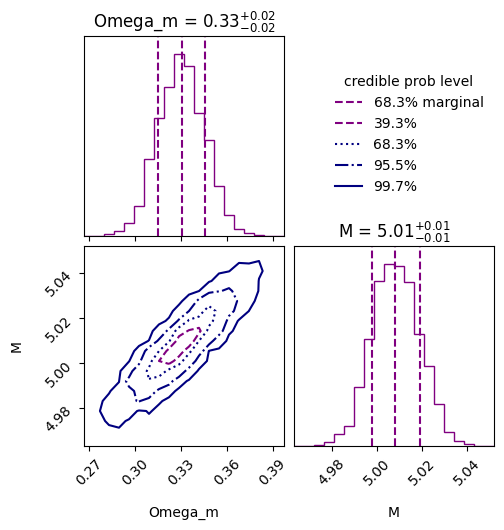

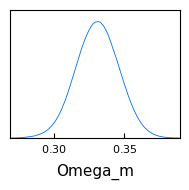

In [48]:
with open(f'{fit_dir}/Flat_LCDM_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)
cornerplot(Flat_LCDM_result);
smooth_plot(Flat_LCDM_result)

#### Open LCDM

In [ ]:
Open_LCDM_result = fit_cosmology("Open_LCDM")
with open(f'{fit_dir}/Open_LCDM_result.pkl', 'wb') as f:
    pickle.dump(Open_LCDM_result, f)

Removed no burn in


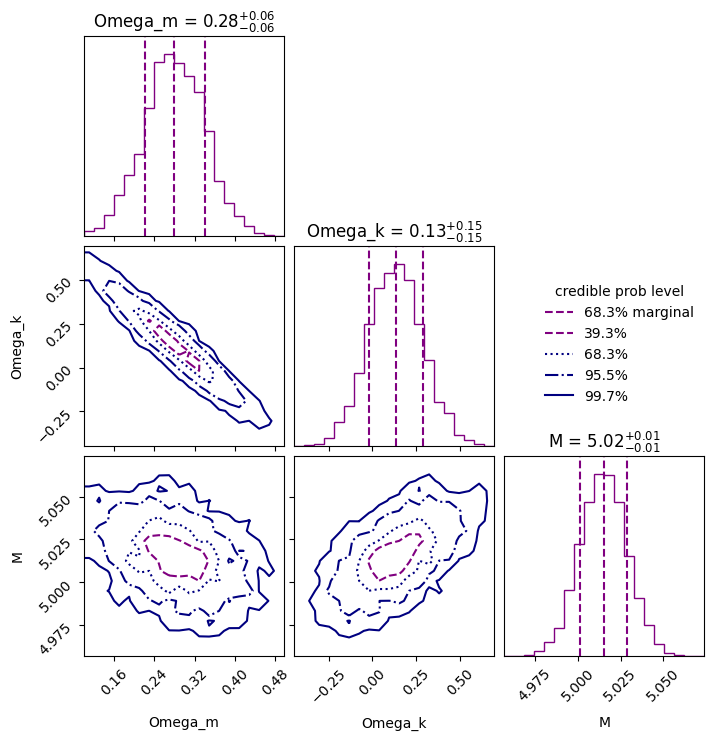

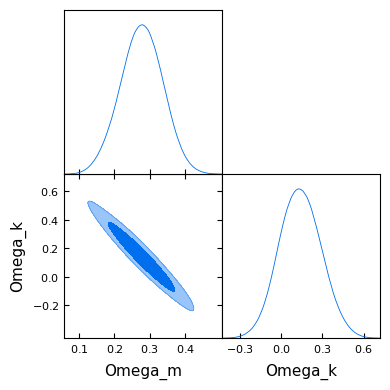

In [49]:
with open(f'{fit_dir}/Open_LCDM_result.pkl', 'rb') as f:
    Open_LCDM_result = pickle.load(f)
cornerplot(Open_LCDM_result);
smooth_plot(Open_LCDM_result)

#### Flat wCDM

In [ ]:
Flat_wCDM_result = fit_cosmology("Flat_wCDM")
with open(f'{fit_dir}/Flat_wCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_wCDM_result, f)

Removed no burn in


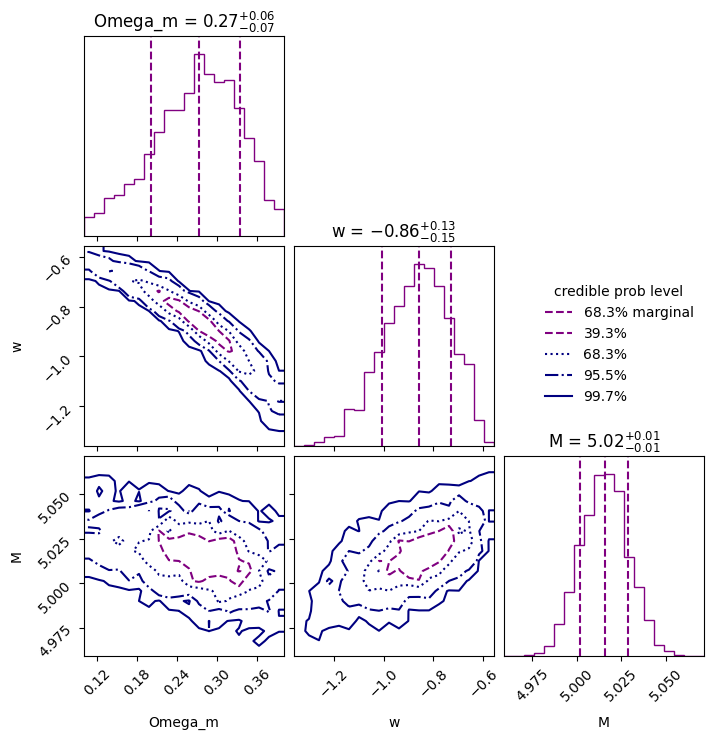

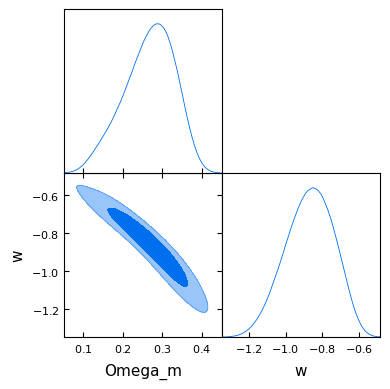

In [50]:
with open(f'{fit_dir}/Flat_wCDM_result.pkl', 'rb') as f:
    Flat_wCDM_result = pickle.load(f)
cornerplot(Flat_wCDM_result);
smooth_plot(Flat_wCDM_result)

#### Flat w0waCDM

In [ ]:
Flat_w0waCDM_result = fit_cosmology("Flat_w0waCDM")
with open(f'{fit_dir}/Flat_w0waCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_w0waCDM_result, f)

Removed no burn in


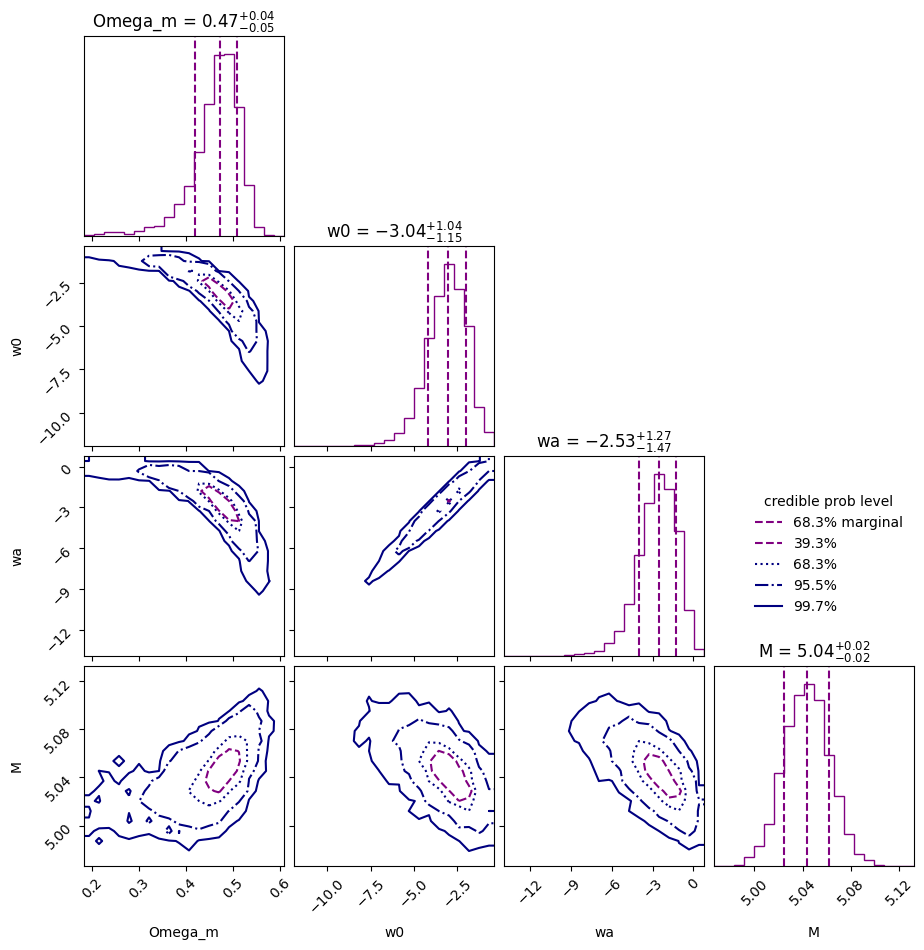

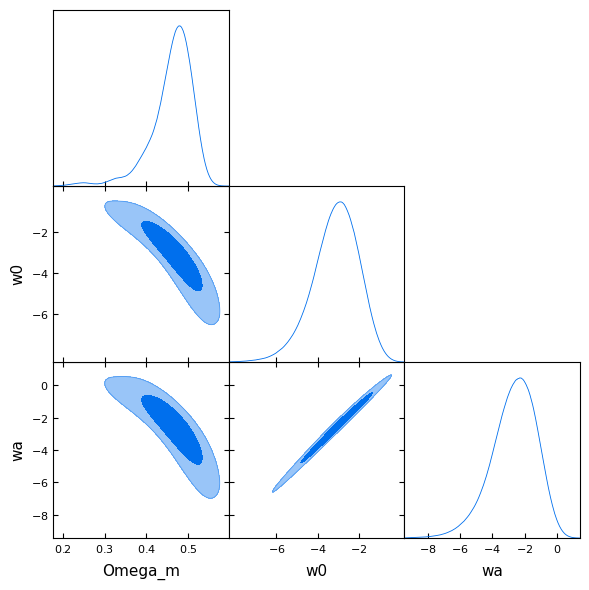

In [51]:
with open(f'{fit_dir}/Flat_w0waCDM_result.pkl', 'rb') as f:
    Flat_w0waCDM_result = pickle.load(f)
cornerplot(Flat_w0waCDM_result);
smooth_plot(Flat_w0waCDM_result)

## Crossmatch

### Match LSC Bricks


### Find Nearest Galaxy for a SN
probably not the host galaxy, because the search range is 20.0 arcsec, too large

In [ ]:
# find host galaxy for a SNe
import requests
import os
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")


def download_brick(SN_id, save_path, overwrite=False, dr=10):
    if os.path.exists(save_path) & (not overwrite):
        print(f"→ {os.path.basename(save_path)} already exists")
        return True

    url = f"https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr{dr}/{SN_sample['SKY'][SN_id]}/tractor/{SN_sample['BRICKNAME'][SN_id][:3]}/tractor-{SN_sample['BRICKNAME'][SN_id]}.fits"
    try:
        resp = requests.get(url, stream=True, timeout=30)
        resp.raise_for_status()

        with open(save_path, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"✓ {os.path.basename(save_path)} found for dr {dr} SN id {SN_id}")
        resp.close()
        return True

    except Exception as e:
        if "resp" in locals():
            resp.close()
        print(f"✗ {os.path.basename(save_path)} - {e}")
        return False


def find_nearest_object_in_brick(
    sn_ra,
    sn_dec,
    tractor_file_path,
    search_radius_arcsec=5.0,
    clear_cache=False,
    include_types=["REX", "SER", "DEV", "EXP"],  # 可以排除多种类型
):
    try:
        with fits.open(tractor_file_path, memmap=False) as hdul:
            data = hdul[1].data
    except Exception as e:
        print(f"读取文件失败: {e}")
        return None

    if clear_cache:
        os.remove(tractor_file_path)

    # 提取坐标数据
    brick_ra = data["ra"]
    brick_dec = data["dec"]

    # 创建SkyCoord对象
    sn_coord = SkyCoord(ra=sn_ra * u.degree, dec=sn_dec * u.degree, frame="icrs")
    brick_coords = SkyCoord(
        ra=brick_ra * u.degree, dec=brick_dec * u.degree, frame="icrs"
    )

    # 计算与所有天体的角距离
    separations = sn_coord.separation(brick_coords)

    # 找出在搜索半径内的天体
    within_radius = separations.arcsecond <= search_radius_arcsec
    indices_within = np.where(within_radius)[0]

    if len(indices_within) == 0:
        # print(f"在 {search_radius_arcsec} 角秒半径内未找到任何天体")
        return None

    # 按距离排序索引
    sorted_indices = indices_within[np.argsort(separations[indices_within].arcsecond)]

    # 寻找合适的天体
    selected_idx = None
    selected_separation = None
    excluded_count = 0

    for idx in sorted_indices:
        current_separation = separations[idx].arcsecond
        obj_type = data[idx]["type"]

        # 如果是字符串类型，去除空白字符
        if isinstance(obj_type, str):
            obj_type = obj_type.strip()

        # 检查是否需要排除该类型
        if not (obj_type in include_types):
            excluded_count += 1
            continue  # 跳过排除的类型

        selected_idx = idx
        selected_separation = current_separation
        break

    if selected_idx is None:
        print(f"在搜索半径内未找到符合条件的天体")
        return None

    # 提取选定天体的信息
    obj_data = data[selected_idx]

    # 创建结果表格
    result = ast.Table()
    for name in obj_data.array.names:
        result[name] = [obj_data.field(name)]
    result["dist"] = selected_separation
    result["excluded_count"] = excluded_count
    if not excluded_count == 0:
        print(f"排除了最近的非星系{excluded_count}个")

    return result


def find_host_galaxy(
    SN_id,
    tractor_dir="tractor_data",
    host_galaxy_save_dir="host_galaxy",
    drs=[10, 9],
    overwrite=False,
    clear_cache=False,
    search_radius_arcsec=15.0,
):
    """
    return nearest object table and nearest separation (arcsec), None for failure
    """
    if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
        return ast.Table.read(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits")
    nearest_obj = None
    for dr in drs:
        os.makedirs(
            f"{tractor_dir}/dr{dr}", exist_ok=True
        )  # exist_ok=True 防止目录已存在时报错
        tractor_file_path = (
            f"{tractor_dir}/dr{dr}/tractor-{SN_sample['BRICKNAME'][SN_id]}.fits"
        )
        if not download_brick(
            SN_id=SN_id, save_path=tractor_file_path, overwrite=overwrite, dr=dr
        ):
            print("download failed")
            continue

        current_nearest_obj = find_nearest_object_in_brick(
            sn_ra=SN_sample["RA"][SN_id],
            sn_dec=SN_sample["DEC"][SN_id],
            tractor_file_path=tractor_file_path,
            search_radius_arcsec=search_radius_arcsec,
            clear_cache=clear_cache,
            include_types=["REX", "SER", "DEV", "EXP"],
        )

        if current_nearest_obj is None:
            continue

        if not (current_nearest_obj["type"][0] in ["REX", "SER", "DEV", "EXP"]):
            print(f"nearest not galaxy but {current_nearest_obj['type'][0]}")
            continue

        if (nearest_obj is None) or (
            nearest_obj["dist"][0] > current_nearest_obj["dist"][0]
        ):
            nearest_obj = current_nearest_obj
            nearest_obj["dr"] = [dr]

    if not (nearest_obj is None):
        nearest_obj['ID'] = [SN_id]
        nearest_obj = nearest_obj[['ID'] + [col for col in nearest_obj.colnames if col != 'ID']]
        nearest_obj.write(
            f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits", overwrite=True
        )

    return nearest_obj


def count_success(host_galaxy_save_dir="host_galaxy"):
    # 数一下成功找到了多少个宿主星系
    success_cnt = 0
    for SN_id in range(num_samples):
        if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
            success_cnt += 1
    print(f"success: {success_cnt}/{num_samples}")


def read_host_galaxy(SN_id, host_galaxy_save_dir="host_galaxy"):
    # 读取SN_id对应的宿主星系信息
    if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
        return ast.Table.read(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits")
    else:
        return None

In [ ]:
# 并行跑（可能有问题，需要跑完后重复跑一遍再非并行跑一遍，因为clear_cache时另一个进程可能正在读这个文件导致错误)
from concurrent.futures import ThreadPoolExecutor

host_galaxy_save_dir = "host_galaxy"
search_radius_arcsec = 20.0  # 设置搜索半径
os.makedirs(host_galaxy_save_dir, exist_ok=True)
with ThreadPoolExecutor(max_workers=6) as executor:
    results = list(
        executor.map(
            lambda SN_id: find_host_galaxy(
                SN_id=SN_id,
                tractor_dir="tractor_data",
                host_galaxy_save_dir=host_galaxy_save_dir,
                overwrite=True,
                clear_cache=True,  # False to save files
                search_radius_arcsec=search_radius_arcsec,
            ),
            range(num_samples),
        )
    )

count_success(host_galaxy_save_dir=host_galaxy_save_dir)

In [ ]:
# TODO: 目前已知0号有问题，去SIMBAD查不到host galaxy，不知道还有没有更多匹配错误的SN (但老师说匹配不上无所谓，少一些就少一些)
SN_sample[0]

In [24]:
# 非并行跑
os.makedirs(host_galaxy_save_dir, exist_ok=True)
for SN_id in tqdm(range(num_samples)): # 逐个跑
    host_galaxy = find_host_galaxy(
        SN_id,
        tractor_dir="tractor_data",
        host_galaxy_save_dir=host_galaxy_save_dir,
        overwrite=True,
        clear_cache=True,
    )

count_success(host_galaxy_save_dir=host_galaxy_save_dir)

  0%|          | 0/1820 [00:00<?, ?it/s]

✗ tractor-1054p142.fits - 404 Client Error: Not Found for url: https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/tractor/105/tractor-1054p142.fits
download failed
✗ tractor-1054p142.fits - 404 Client Error: Not Found for url: https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/105/tractor-1054p142.fits
download failed
✗ tractor-1093p097.fits - 404 Client Error: Not Found for url: https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/tractor/109/tractor-1093p097.fits
download failed
✗ tractor-1093p097.fits - 404 Client Error: Not Found for url: https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/109/tractor-1093p097.fits
download failed
✗ tractor-1081p072.fits - 404 Client Error: Not Found for url: https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/tractor/108/tractor-1081p072.fits
download failed
✗ tractor-1081p072.fits - 404 Client Error: Not Found for url: https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/d

### Find Host Galaxy for a SN
distance <1.0 arcsec

In [ ]:
# 筛选符合条件的galaxy
max_dist_arcsec = 1.0
valid_SN_ids = []
valid_host_galaxies = []
for SN_id in tqdm(range(num_samples)):
    host_galaxy = read_host_galaxy(SN_id, host_galaxy_save_dir=host_galaxy_save_dir)
    if host_galaxy is None:
        continue
    # 筛选条件：距离小于max_dist_arcsec且类型为星系
    if (host_galaxy['dist'][0] <= max_dist_arcsec) and (host_galaxy['type'][0] in ['REX', 'SER', 'DEV', 'EXP']):
        valid_SN_ids.append(SN_id)
        valid_host_galaxies.append(host_galaxy)

# 符合条件的SNe数量
print(f'{len(valid_SN_ids)}/{num_samples} SNe have valid host galaxies within {max_dist_arcsec} arcsec')

  0%|          | 0/1820 [00:00<?, ?it/s]

1196/1820 SNe have valid host galaxies within 1.0 arcsec


In [44]:
# 随便查看一个
valid_host_galaxies[0] # ID与SN_sample对应, dist是到SNe距离, type是类型

ID,release,brickid,brickname,objid,brick_primary,maskbits,fitbits,type,ra,dec,ra_ivar,dec_ivar,bx,by,dchisq,ebv,mjd_min,mjd_max,ref_cat,ref_id,pmra,pmdec,parallax,pmra_ivar,pmdec_ivar,parallax_ivar,ref_epoch,gaia_phot_g_mean_mag,gaia_phot_g_mean_flux_over_error,gaia_phot_g_n_obs,gaia_phot_bp_mean_mag,gaia_phot_bp_mean_flux_over_error,gaia_phot_bp_n_obs,gaia_phot_rp_mean_mag,gaia_phot_rp_mean_flux_over_error,gaia_phot_rp_n_obs,gaia_phot_variable_flag,gaia_astrometric_excess_noise,gaia_astrometric_excess_noise_sig,gaia_astrometric_n_obs_al,gaia_astrometric_n_good_obs_al,gaia_astrometric_weight_al,gaia_duplicated_source,gaia_a_g_val,gaia_e_bp_min_rp_val,gaia_phot_bp_rp_excess_factor,gaia_astrometric_sigma5d_max,gaia_astrometric_params_solved,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,fiberflux_g,fiberflux_r,fiberflux_z,fibertotflux_g,fibertotflux_r,fibertotflux_z,apflux_g,apflux_r,apflux_z,apflux_resid_g,apflux_resid_r,apflux_resid_z,apflux_blobresid_g,apflux_blobresid_r,apflux_blobresid_z,apflux_ivar_g,apflux_ivar_r,apflux_ivar_z,apflux_masked_g,apflux_masked_r,apflux_masked_z,apflux_w1,apflux_w2,apflux_w3,apflux_w4,apflux_resid_w1,apflux_resid_w2,apflux_resid_w3,apflux_resid_w4,apflux_ivar_w1,apflux_ivar_w2,apflux_ivar_w3,apflux_ivar_w4,mw_transmission_g,mw_transmission_r,mw_transmission_z,mw_transmission_w1,mw_transmission_w2,mw_transmission_w3,mw_transmission_w4,nobs_g,nobs_r,nobs_z,nobs_w1,nobs_w2,nobs_w3,nobs_w4,rchisq_g,rchisq_r,rchisq_z,rchisq_w1,rchisq_w2,rchisq_w3,rchisq_w4,fracflux_g,fracflux_r,fracflux_z,fracflux_w1,fracflux_w2,fracflux_w3,fracflux_w4,fracmasked_g,fracmasked_r,fracmasked_z,fracin_g,fracin_r,fracin_z,anymask_g,anymask_r,anymask_z,allmask_g,allmask_r,allmask_z,wisemask_w1,wisemask_w2,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,nea_g,nea_r,nea_z,blob_nea_g,blob_nea_r,blob_nea_z,psfdepth_w1,psfdepth_w2,psfdepth_w3,psfdepth_w4,wise_coadd_id,wise_x,wise_y,lc_flux_w1,lc_flux_w2,lc_flux_ivar_w1,lc_flux_ivar_w2,lc_nobs_w1,lc_nobs_w2,lc_fracflux_w1,lc_fracflux_w2,lc_rchisq_w1,lc_rchisq_w2,lc_mjd_w1,lc_mjd_w2,lc_epoch_index_w1,lc_epoch_index_w2,sersic,sersic_ivar,shape_r,shape_r_ivar,shape_e1,shape_e1_ivar,shape_e2,shape_e2_ivar,dist,excluded_count,dr
int64,int16,int32,bytes8,int32,bool,int16,int16,bytes3,float64,float64,float32,float32,float32,float32,float32[5],float32,float64,float64,bytes1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,bool,float32,float32,int16,int16,float32,bool,float32,float32,float32,float32,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[8],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32[5],float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32[15],float32[15],float32[15],float32[15],int16[15],int16[15],float32[15],float32[15],float32[15],float32[15],float64[15],float64[15],int16[15],int16[15],float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,int64
17,9010,407397,3347p132,3544,True,0,0,SER,334.7869083949392,13.177907597702697,1.0416741e+13,1.1102861e+13

In [ ]:
# 接下来可以用valid_host_galaxies来做后续分析了